In this notebook, we will work with data from the CIA World Factbook. The Factbook contains demographic information about all of the countries on Earth, e.g. population, population growth, area, etc. 

In [1]:
# import libraries
import sqlite3
import pandas as pd

# establish a connexion to the database
conn = sqlite3.connect("factbook.db")

Run a query to return information on the tables in the database.

In [2]:
q1 = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q1, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."
2,table,cities,cities,2,CREATE TABLE cities (\n id integer prim...


Run a query that returns the first 5 rows of the facts table in the database.

In [3]:
q2 = "select * from facts limit 5"
pd.read_sql_query(q2, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Run query that returns the minimum population, the maximum population, the minimum population growth, and the maximum population growth.

In [4]:
q3 = '''
select min(population) min_pop, max(population) max_pop, 
min(population_growth) min_pop_grwth, max(population_growth) max_pop_grwth 
from facts
'''
pd.read_sql_query(q3, conn)

,min_pop,max_pop,min_pop_grwth,max_pop_grwth
0,0,7256490011,0.0,4.02


A few things stick out from the summary statistics in the last screen:

- there's a country with a population of 0,
- there's a country with a population of than 7.2 billion people.

Let's try to find these outliers.

In [5]:
q4 = '''
select *
from facts
where population == (select max(population) from facts);
'''

pd.read_sql_query(q4, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


In [6]:
q5 = '''
select *
from facts
where population == (select min(population) from facts);
'''

pd.read_sql_query(q5, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


It turns out that the two outliers are the world and the Antarctica which explain the abnormal population count.

Using the non-outlier rows, we generate a 2x2 grid of histograms for the columns: population, population_growth, birth_rate, and death_rate.

C:\Users\chaouki\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3267: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002402777B240>,
      dtype=object)

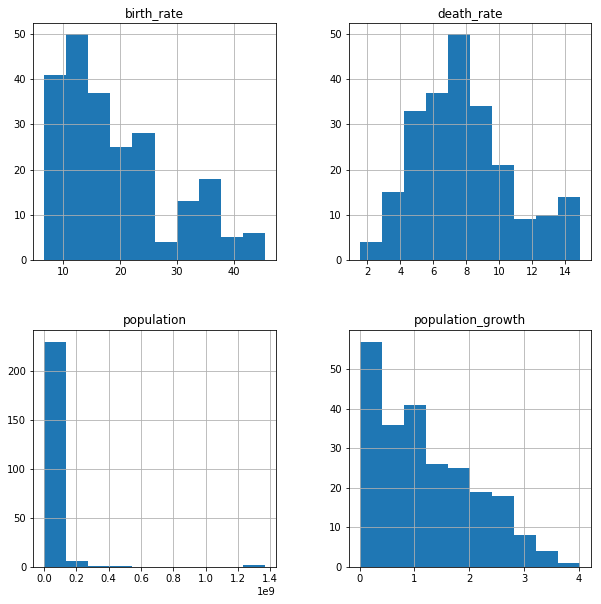

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

q6 = '''
select population, population_growth, birth_rate, death_rate
from facts
where population != (select max(population) from facts)
and population != (select min(population) from facts);
'''
pd.read_sql_query(q6, conn).hist(ax=ax)

Run a query to determine the first 20 countries that have the highest population density.

In [8]:
q7 = "select name, cast(population as float)/cast(area as float) density from facts order by density desc limit 20"
pd.read_sql_query(q7, conn)

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


In [9]:
q8 = '''SELECT * FROM facts
INNER JOIN cities ON cities.facts_id = facts.id
LIMIT 10'''
pd.read_sql_query(q8, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,id,name,population,capital,facts_id
0,216,aa,Aruba,180,180,0,112162,1.33,12.56,8.18,8.92,1,Oranjestad,37000,1,216
1,6,ac,Antigua and Barbuda,442,442,0,92436,1.24,15.85,5.69,2.21,2,Saint John'S,27000,1,6
2,184,ae,United Arab Emirates,83600,83600,0,5779760,2.58,15.43,1.97,12.36,3,Abu Dhabi,942000,1,184
3,184,ae,United Arab Emirates,83600,83600,0,5779760,2.58,15.43,1.97,12.36,4,Dubai,1978000,0,184
4,184,ae,United Arab Emirates,83600,83600,0,5779760,2.58,15.43,1.97,12.36,5,Sharjah,983000,0,184
5,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51,6,Kabul,3097000,1,1
6,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,7,Algiers,2916000,1,3
7,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92,8,Oran,783000,0,3
8,11,aj,Azerbaijan,86600,82629,3971,9780780,0.96,16.64,7.07,0.00,9,Baku,2123000,1,11
9,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30,10,Tirana,419000,1,2


Run a query that return the country name and its capital city.

In [10]:
q9 = '''SELECT f.name country, c.name capital_city FROM cities c
INNER JOIN facts f ON f.id = c.facts_id
WHERE c.capital = 1'''
pd.read_sql_query(q9, conn)

,country,capital_city
0,Aruba,Oranjestad
1,Antigua and Barbuda,Saint John'S
2,United Arab Emirates,Abu Dhabi
3,Afghanistan,Kabul
4,Algeria,Algiers
5,Azerbaijan,Baku
6,Albania,Tirana
7,Armenia,Yerevan
8,Andorra,Andorra La Vella
9,Angola,Luanda


Run a query that returns the 10 capital cities with the highest population ranked from biggest to smallest population.

In [13]:
q10 = '''SELECT f.name country, c.name capital_city FROM cities c
INNER JOIN facts f ON f.id = c.facts_id
WHERE c.capital = 1
LIMIT 10'''
pd.read_sql_query(q10, conn)

,country,capital_city
0,Aruba,Oranjestad
1,Antigua and Barbuda,Saint John'S
2,United Arab Emirates,Abu Dhabi
3,Afghanistan,Kabul
4,Algeria,Algiers
5,Azerbaijan,Baku
6,Albania,Tirana
7,Armenia,Yerevan
8,Andorra,Andorra La Vella
9,Angola,Luanda


Run a query that returns capital cities with populations of over 10 million ordered from largest to smallest.

In [15]:
q11 = '''SELECT c.name capital_city, f.name country, c.population FROM facts f INNER JOIN (SELECT * FROM cities WHERE capital = 1) c 
ON c.facts_id = f.id 
WHERE c.population > 10000000 
ORDER BY c.population DESC'''
pd.read_sql_query(q11, conn)

,capital_city,country,population
0,Tokyo,Japan,37217000
1,New Delhi,India,22654000
2,Mexico City,Mexico,20446000
3,Beijing,China,15594000
4,Dhaka,Bangladesh,15391000
5,Buenos Aires,Argentina,13528000
6,Manila,Philippines,11862000
7,Moscow,Russia,11621000
8,Cairo,Egypt,11169000


Run a query that returns only the countries where the percentage of the popularion within urban areas is greater than 0.5 and order them in ascending order.

In [16]:
q12 = '''SELECT f.name country, c.urban_pop,  f.population total_pop, CAST(c.urban_pop as FLOAT)/CAST(f.population as FLOAT) urban_pct FROM facts f INNER JOIN (SELECT facts_id, SUM(population) urban_pop FROM cities GROUP BY facts_id) c 
ON c.facts_id = f.id 
WHERE urban_pct > 0.5 
ORDER BY urban_pct'''
pd.read_sql_query(q12, conn)

,country,urban_pop,total_pop,urban_pct
0,Uruguay,1672000,3341893,0.500315
1,"Congo, Republic of the",2445000,4755097,0.514185
2,Brunei,241000,429646,0.560927
3,New Caledonia,157000,271615,0.578024
4,Virgin Islands,60000,103574,0.579296
5,Falkland Islands (Islas Malvinas),2000,3361,0.595061
6,Djibouti,496000,828324,0.598800
7,Australia,13789000,22751014,0.606083
8,Iceland,206000,331918,0.620635
9,Israel,5226000,8049314,0.649248
